# Importación liberias

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Carga datos

Cargamos los distintos Csv que hemos preparado para entrenar los modelos, estos se encuentran en la carpeta `data/processed`

# Modelo-1

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

file_name = "Propensity_clean_v1.csv"  # Cambiar a "v2", "v3", "v4" para trabajar con ostros csv
file_path = os.path.join(DATA_DIR, file_name)

df = pd.read_csv(file_path)

## Búsqueda Hiperparámetros-XGboost

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

In [4]:
# 📌 1️⃣ Cargar los datos (asumiendo que ya lo tienes cargado en df)
df = df.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante

# 📌 2️⃣ Definir X e y
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar en XGBoost
param_grid = {
    'n_estimators': [500],  # Número de árboles (suficientes para estabilidad)
    'learning_rate': [0.1],  # Tasa de aprendizaje
    'max_depth': [3,5,8],  # Profundidad de los árboles
    'min_child_weight': [3,5],  # Controla división de nodos
    'gamma': [0, 0.1, 0.3],  # Penalización para reducir sobreajuste
    'subsample': [0.7, 0.9],  # Muestreo aleatorio de instancias
    'colsample_bytree': [0.7,0.9],  # Muestreo de características
    'lambda': [1, 3],  # Regularización L2
    'alpha': [0, 1],  # Regularización L1
}

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, 
     colsample_bytree, lambda_, alpha) = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=lambda_,
        reg_alpha=alpha,
        random_state=42,
  
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambda_,
        'alpha': alpha,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"n_estimators: {n_estimators}, Learning Rate: {learning_rate}, Max Depth: {max_depth}, Min Child Weight: {min_child_weight}, Gamma: {gamma}, Subsample: {subsample}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'n_estimators: {row["n_estimators"]}, Learning Rate: {row["learning_rate"]}, Max Depth: {row["max_depth"]}, Min Child Weight: {row["min_child_weight"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - XGBoost')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - XGBoost')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8301, F1 Score: 0.8279, Recall: 0.8301, ROC-AUC: 0.9175, CV Score: 0.9190, Train Score: 0.8502, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8333, F1 Score: 0.8311, Recall: 0.8333, ROC-AUC: 0.9174, CV Score: 0.9190, Train Score: 0.8502, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8292, F1 Score: 0.8268, Recall: 0.8292, ROC-AUC: 0.9172, CV Score: 0.9187, Train Score: 0.8480, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8305, F1 Score: 0.8282, Recall: 0.8305, ROC-AUC: 0.9172, CV Score: 0.9189, Train Score: 0.8472, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accur

KeyboardInterrupt: 

## Selección final

In [ ]:
#guardar en fichero csv todos los resultados
results_df

,n_estimators,learning_rate,max_depth,min_child_weight,gamma,subsample,colsample_bytree,lambda,alpha,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
104,500,0.1,5,3,0.0,0.9,0.7,1,0,0.845422,0.844082,0.845422,0.929815,0.928066,0.903272,OK
108,500,0.1,5,3,0.0,0.9,0.9,1,0,0.844742,0.843427,0.844742,0.929003,0.928069,0.906644,OK
202,500,0.1,8,3,0.0,0.9,0.7,3,0,0.844175,0.843359,0.844175,0.928340,0.927055,0.970024,OK
252,500,0.1,8,5,0.0,0.9,0.9,1,0,0.843268,0.842723,0.843268,0.926911,0.925205,0.971951,OK
173,500,0.1,5,5,0.1,0.9,0.9,1,1,0.843948,0.842604,0.843948,0.928332,0.927896,0.901119,OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,500,0.1,3,5,0.0,0.7,0.7,3,0,0.829102,0.826702,0.829102,0.916307,0.918785,0.848194,OK
48,500,0.1,3,5,0.0,0.7,0.7,1,0,0.828876,0.826691,0.828876,0.917713,0.919019,0.849950,OK
64,500,0.1,3,5,0.1,0.7,0.7,1,0,0.828762,0.826477,0.828762,0.917799,0.918896,0.849695,OK
18,500,0.1,3,3,0.1,0.7,0.7,3,0,0.828422,0.826178,0.828422,0.916896,0.918603,0.847315,OK


Guardamos los  resultados obtenidos de las iteraciones en el arhcivo `results.csv`

In [ ]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")  # Carpeta 'data'

os.makedirs(DATA_DIR, exist_ok=True)

# 📌 Guardar el DataFrame en un archivo CSV dentro de la carpeta 'data'
file_path = os.path.join(DATA_DIR, "results_v1.csv")
results_df.to_csv(file_path, index=False)  # index=False para no guardar el índice

print(f"Archivo guardado en: {file_path}")

Archivo guardado en: /Users/martinagarciagonzalez/ia_propensity-2/data/results.csv


# Modelo-2

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

file_name = "Propensity_clean_v5.csv"  # Cambiar a "v2", "v3", "v4" para trabajar con ostros csv
file_path = os.path.join(DATA_DIR, file_name)

df_5 = pd.read_csv(file_path)

In [3]:
df_5

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0,1,0,0,1,1,4,...,3,0,3,1,2892,0,0,2,18,0
1,0,0,0,0,1,0,0,0,1,47,...,3,1,0,0,1376,7187,0,2,53,0
2,0,0,0,0,1,3,0,1,1,30,...,2,0,0,0,1376,0,1,4,21,3
3,0,0,0,0,1,2,0,0,1,32,...,2,1,3,1,2015,7256,1,4,48,5
4,0,0,0,0,1,2,0,0,2,41,...,0,0,0,0,1818,0,1,3,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58043,5,2,0,2,1,0,3,0,1,32,...,1,1,3,1,6832,12528,0,5,38,0
58044,10,6,0,2,0,0,0,1,1,2,...,3,0,0,1,0,22072,0,3,54,0
58045,10,6,0,2,0,0,0,1,1,32,...,2,0,0,0,0,8352,0,8,63,0
58046,6,4,1,1,1,0,0,1,1,52,...,3,0,0,0,2786,10441,0,13,62,0


n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8614, F1 Score: 0.8594, Recall: 0.8614, ROC-AUC: 0.9359, CV Score: 0.9342, Train Score: 0.8676, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8615, F1 Score: 0.8595, Recall: 0.8615, ROC-AUC: 0.9359, CV Score: 0.9342, Train Score: 0.8682, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8581, F1 Score: 0.8560, Recall: 0.8581, ROC-AUC: 0.9351, CV Score: 0.9342, Train Score: 0.8676, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8588, F1 Score: 0.8565, Recall: 0.8588, ROC-AUC: 0.9353, CV Score: 0.9336, Train Score: 0.8665, Overfitting: OK

n_estimators: 500, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accur

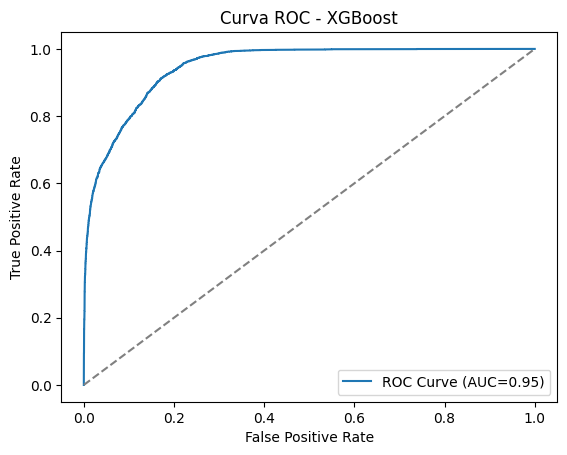

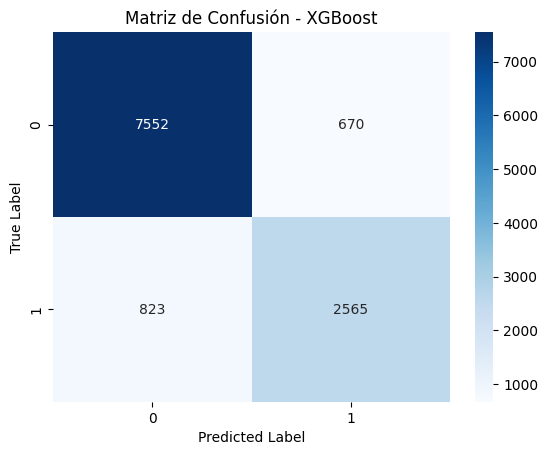


--------------------------------------------------
Modelo Optimizado 111
--------------------------------------------------
n_estimators: 500, Learning Rate: 0.1, Max Depth: 5, Min Child Weight: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8222
           1       0.79      0.76      0.77      3388

    accuracy                           0.87     11610
   macro avg       0.85      0.84      0.84     11610
weighted avg       0.87      0.87      0.87     11610


ROC-AUC Score: 0.9479335360798067



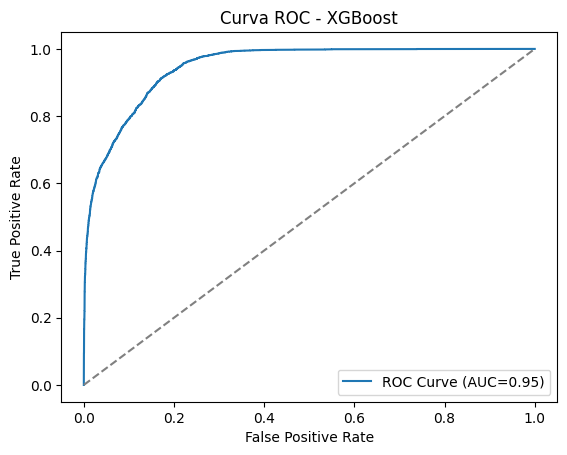

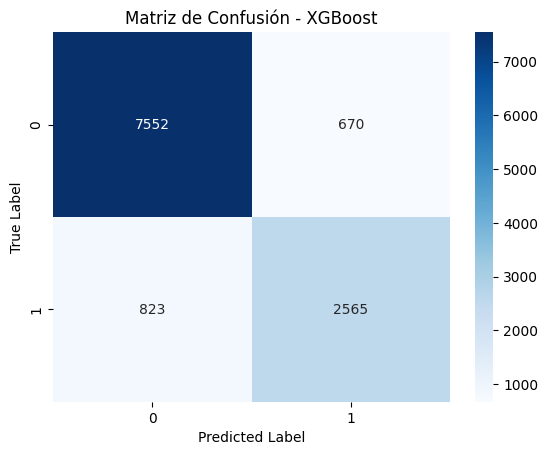


--------------------------------------------------
Modelo Optimizado 110
--------------------------------------------------
n_estimators: 500, Learning Rate: 0.1, Max Depth: 5, Min Child Weight: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8222
           1       0.79      0.76      0.77      3388

    accuracy                           0.87     11610
   macro avg       0.85      0.84      0.84     11610
weighted avg       0.87      0.87      0.87     11610


ROC-AUC Score: 0.9479335360798067



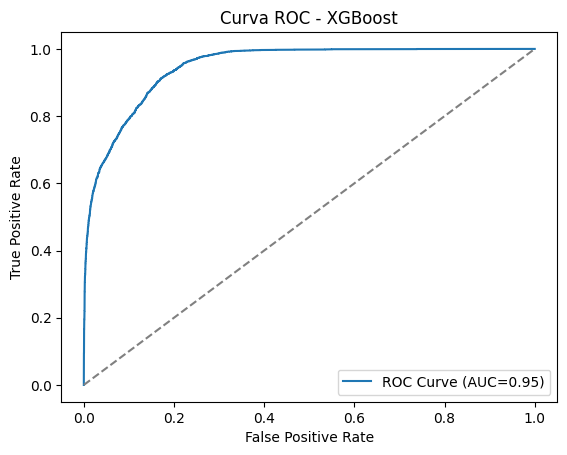

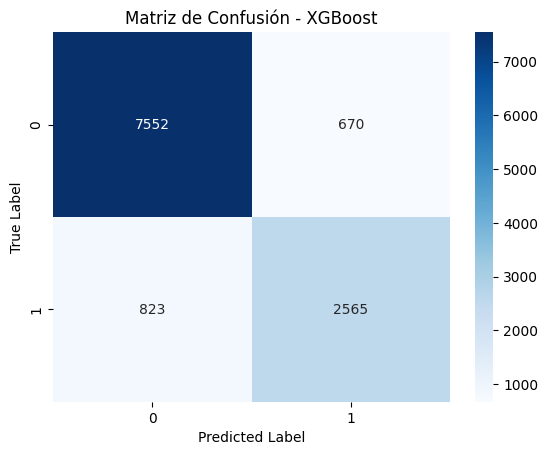

,n_estimators,learning_rate,max_depth,min_child_weight,gamma,subsample,colsample_bytree,lambda,alpha,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
232,500,0.1,8,3,0.3,0.9,0.7,1,0,0.875883,0.875045,0.875883,0.949423,0.946107,0.973987,OK
110,500,0.1,5,3,0.0,0.9,0.9,3,0,0.875538,0.874192,0.875538,0.947667,0.945667,0.911603,OK
109,500,0.1,5,3,0.0,0.9,0.9,1,1,0.874935,0.873588,0.874935,0.947876,0.945340,0.915608,OK


In [7]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

df_5 = df_5.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante si existe

# 📌 2️⃣ Definir X e y
y = df_5["Mas_1_coche"]
X = df_5.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar en XGBoost
param_grid = {
    'n_estimators': [500],  
    'learning_rate': [0.1],  
    'max_depth': [3, 5, 8],  
    'min_child_weight': [3, 5],  
    'gamma': [0, 0.1, 0.3],  
    'subsample': [0.7, 0.9],  
    'colsample_bytree': [0.7, 0.9],  
    'lambda': [1, 3],  
    'alpha': [0, 1],  
}

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, 
     colsample_bytree, lambda_, alpha) = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=lambda_,
        reg_alpha=alpha,
        random_state=42,
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambda_,
        'alpha': alpha,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"n_estimators: {n_estimators}, Learning Rate: {learning_rate}, Max Depth: {max_depth}, Min Child Weight: {min_child_weight}, Gamma: {gamma}, Subsample: {subsample}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df_2 = pd.DataFrame(results)
results_df_2 = results_df_2.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df_2[results_df_2['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'n_estimators: {row["n_estimators"]}, Learning Rate: {row["learning_rate"]}, Max Depth: {row["max_depth"]}, Min Child Weight: {row["min_child_weight"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - XGBoost')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - XGBoost')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)

In [9]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")  # Carpeta 'data'

os.makedirs(DATA_DIR, exist_ok=True)

# 📌 Guardar el DataFrame en un archivo CSV dentro de la carpeta 'data'
file_path = os.path.join(DATA_DIR, "results_v2.csv")
results_df_2.to_csv(file_path, index=False)  # index=False para no guardar el índice

print(f"Archivo guardado en: {file_path}")

Archivo guardado en: /Users/martinagarciagonzalez/ia_propensity-2/data/results_v2.csv


más pruebas con hiperparámetros....

n_estimators: 550, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8617, F1 Score: 0.8596, Recall: 0.8617, ROC-AUC: 0.9368, CV Score: 0.9350, Train Score: 0.8698, Overfitting: OK

n_estimators: 550, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8624, F1 Score: 0.8604, Recall: 0.8624, ROC-AUC: 0.9368, CV Score: 0.9348, Train Score: 0.8703, Overfitting: OK

n_estimators: 550, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8593, F1 Score: 0.8570, Recall: 0.8593, ROC-AUC: 0.9358, CV Score: 0.9349, Train Score: 0.8691, Overfitting: OK

n_estimators: 550, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accuracy: 0.8602, F1 Score: 0.8580, Recall: 0.8602, ROC-AUC: 0.9361, CV Score: 0.9343, Train Score: 0.8689, Overfitting: OK

n_estimators: 550, Learning Rate: 0.1, Max Depth: 3, Min Child Weight: 3, Gamma: 0, Subsample: 0.7
Accur

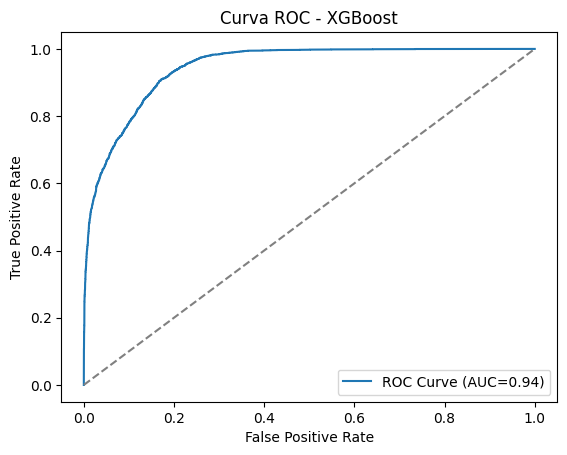

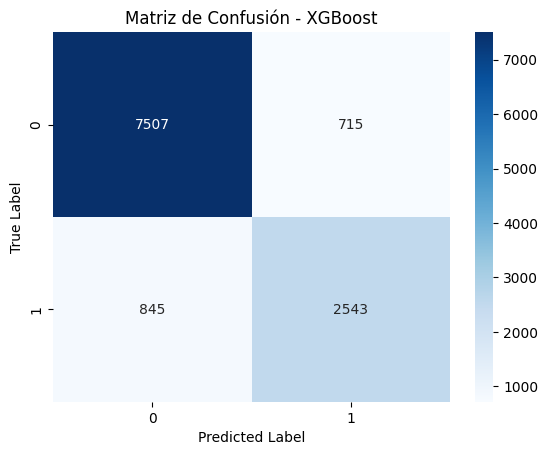


--------------------------------------------------
Modelo Optimizado 111
--------------------------------------------------
n_estimators: 550, Learning Rate: 0.1, Max Depth: 5, Min Child Weight: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      8222
           1       0.78      0.75      0.77      3388

    accuracy                           0.87     11610
   macro avg       0.84      0.83      0.84     11610
weighted avg       0.86      0.87      0.86     11610


ROC-AUC Score: 0.9449368354605966



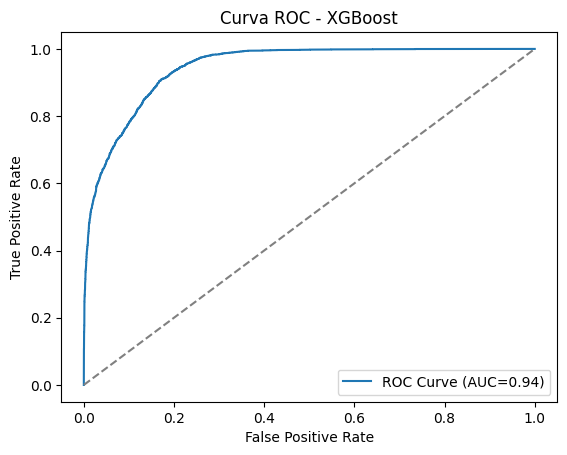

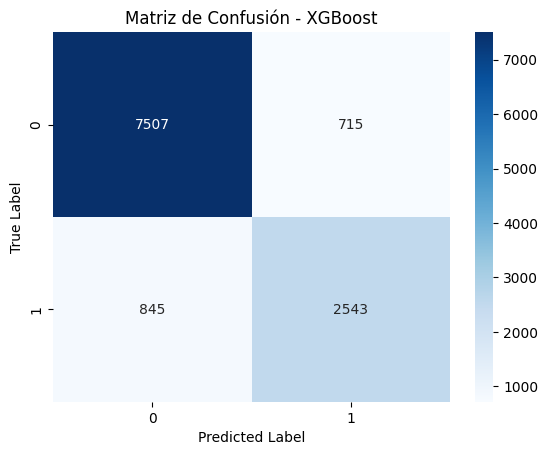


--------------------------------------------------
Modelo Optimizado 141
--------------------------------------------------
n_estimators: 550, Learning Rate: 0.1, Max Depth: 5, Min Child Weight: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      8222
           1       0.78      0.75      0.77      3388

    accuracy                           0.87     11610
   macro avg       0.84      0.83      0.84     11610
weighted avg       0.86      0.87      0.86     11610


ROC-AUC Score: 0.9449368354605966



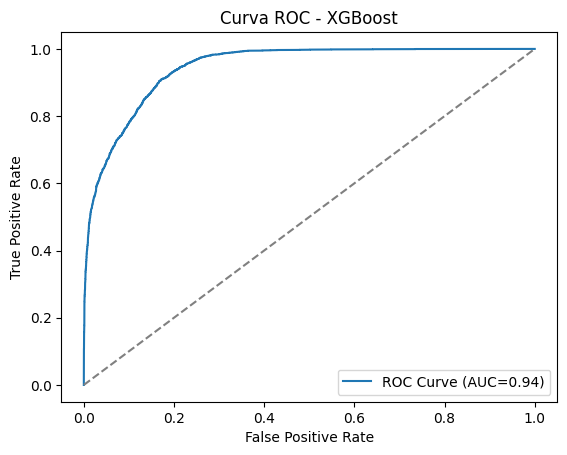

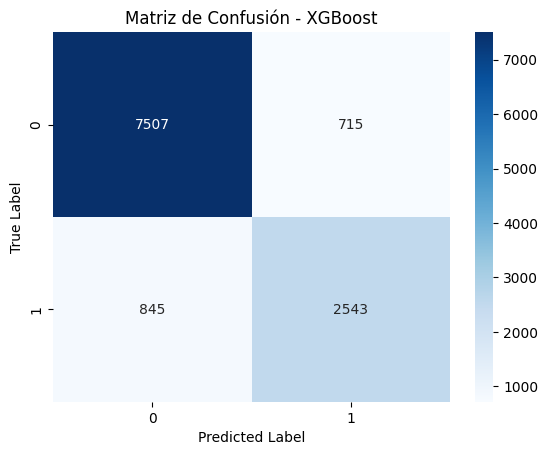

,n_estimators,learning_rate,max_depth,min_child_weight,gamma,subsample,colsample_bytree,lambda,alpha,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
232,550,0.1,8,3,0.3,0.9,0.7,1,0,0.875538,0.874768,0.875538,0.949274,0.945894,0.976700,OK
110,550,0.1,5,3,0.0,0.9,0.9,3,0,0.875452,0.874160,0.875452,0.947811,0.945747,0.914919,OK
140,550,0.1,5,3,0.3,0.9,0.9,1,0,0.874849,0.873445,0.874849,0.948310,0.945771,0.919635,OK


In [ ]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

df_5 = df_5.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante si existe

# 📌 2️⃣ Definir X e y
y = df_5["Mas_1_coche"]
X = df_5.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar en XGBoost
param_grid = {
    'n_estimators': [550],  
    'learning_rate': [0.1,0.2],  
    'max_depth': [3, 5, 8],  
    'min_child_weight': [3, 5],  
    'gamma': [0, 0.1, 0.3],  
    'subsample': [0.7, 0.9],  
    'colsample_bytree': [0.7, 0.9],  
    'lambda': [1, 3],  
    'alpha': [0, 1],  
}

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, 
     colsample_bytree, lambda_, alpha) = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=lambda_,
        reg_alpha=alpha,
        random_state=42,
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda': lambda_,
        'alpha': alpha,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"n_estimators: {n_estimators}, Learning Rate: {learning_rate}, Max Depth: {max_depth}, Min Child Weight: {min_child_weight}, Gamma: {gamma}, Subsample: {subsample}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'n_estimators: {row["n_estimators"]}, Learning Rate: {row["learning_rate"]}, Max Depth: {row["max_depth"]}, Min Child Weight: {row["min_child_weight"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - XGBoost')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - XGBoost')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)